# **Actividad Fundamental N.º 3 - Producto Integrador de Aprendizaje**

## **Instalación de las librerias y la base de datos**

In [20]:
import os
import cv2 #    Módulo para analizar las imágenes
import pandas as pd #   Se utiliza para menejar y analizar los dataframes
import numpy as np #    Para las operaciones matemáticas y trabajar con los arrays
import tensorflow as tf #   Se utiliza, en este caso, para el preprocesamiento de las imágenes
import matplotlib.pyplot as plt #   Ayuda a generar gráficos
import seaborn as sns   #   Esta librería la utilizamos para generar el heatmap de la matríz de confusión

#   Se importan las funciones de Sikit_Learn necesarias para entrenar el modelo y sacar las métricas que evaluan el rendimiento del modelo
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

## **Carga del Dataset**

In [21]:
# Ruta del dataset
FUENTE = "Frutas"

assert os.path.isdir(FUENTE), "Revisa la ruta"
print("Contenido del dataset:")
print(os.listdir(FUENTE))

Contenido del dataset:
['apple fruit', 'banana fruit', 'cherry fruit', 'chickoo fruit', 'grapes fruit', 'kiwi fruit', 'mango fruit', 'orange fruit', 'strawberry fruit']


## **Generación del DataFrame que ayudará al manejo del dataset**

In [22]:
#   Diccionario para cambiar el nombre de las etiquetas a uno más simple y en español
frutas = {'apple fruit' : "Manzana", 'kiwi fruit' : "Kiwi", 'strawberry fruit' : "Fresa", 'cherry fruit' : "Cereza", 'chickoo fruit' : "Sapote", 'orange fruit' : "Naranja", 'grapes fruit' : "Uva", 'mango fruit' : "Mango", 'banana fruit' : "Platano"}

#   Listas para almacenar la ruta y etiqueta correspondiente a cada imagen
filepaths = []
labels = []

#   Ciclo for que se encarga de revisar cada una de las imágenes
for folder_name, class_label in frutas.items():
    folder_path = os.path.join(FUENTE, folder_name)

    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if os.path.isfile(fpath):   #   Agrega la ruta y etiqueta a su lista correspondiente
            filepaths.append(fpath)
            labels.append(class_label)

#   Genera un DataFrame con las listas ya generadas
data_df = pd.DataFrame({"filepath" : filepaths, "label" : labels})
data_df["label"].value_counts() #   Muestra la cantidad de imágenes que hay por etiqueta

label
Manzana    40
Kiwi       40
Fresa      40
Cereza     40
Sapote     40
Naranja    40
Uva        40
Mango      40
Platano    40
Name: count, dtype: int64

## **Validación de imágenes**

In [23]:
#   Función para revisar cada una de las imágenes y revisar si es válida o no
def is_valid_image(path):
    try:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return False
        _ = img.shape
        return True
    except Exception:
        return False

#   Se aplica la función a cada imágen
valid_mask = data_df["filepath"].apply(is_valid_image)
invalid_count = (-valid_mask).sum() #   Se hace una suma de las imágenes invalidas
print("Imágenes invalidas detectadas: ", invalid_count)

#   Se quitan las imágenes inválidas del dataset y se muestra la cantidad de imágenes válidas
data_df = data_df[valid_mask].reset_index(drop = True)
print("Total de imagenes validas", len(data_df))
data_df["label"].value_counts()

Imágenes invalidas detectadas:  0
Total de imagenes validas 360


label
Manzana    40
Kiwi       40
Fresa      40
Cereza     40
Sapote     40
Naranja    40
Uva        40
Mango      40
Platano    40
Name: count, dtype: int64

## **Revisión del Dataset**

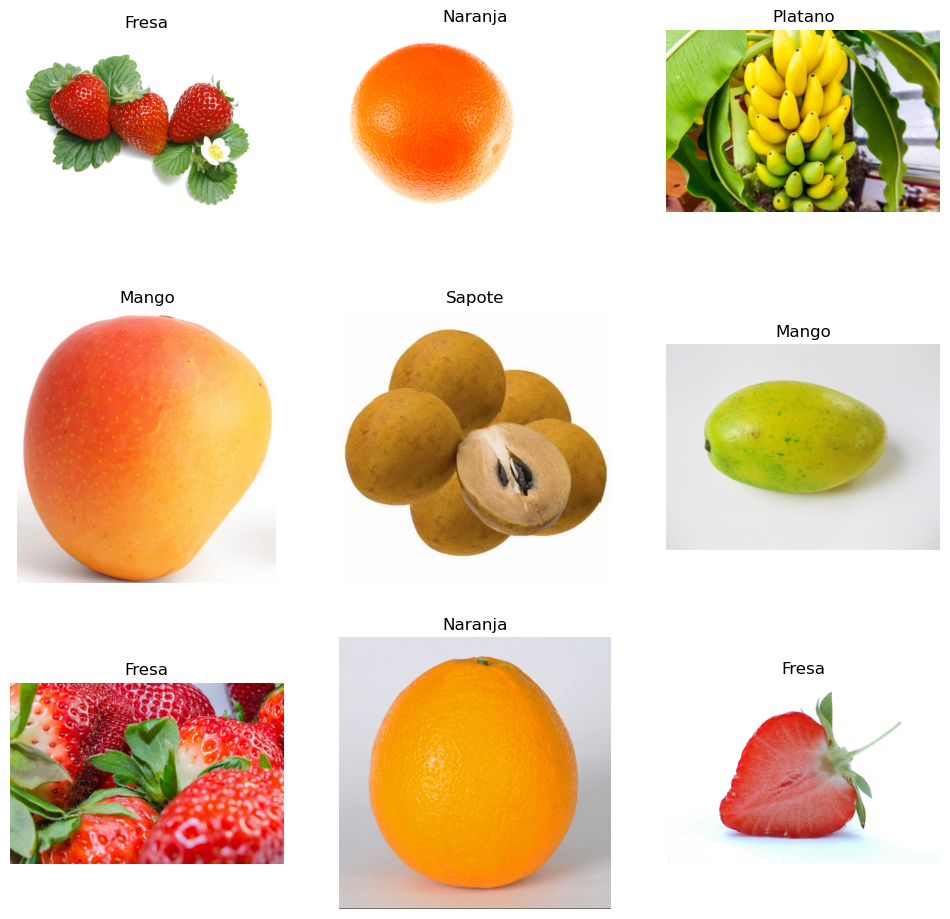

In [31]:
plt.figure(figsize=(12, 12))

#   Se seleccionan 9 imágenes random
random_img= np.random.choice(data_df.index, size=9, replace=False)

for i, idx in enumerate(random_img):
    row = data_df.loc[idx]
    filepath = row["filepath"]
    label = row["label"]

    plt.subplot(3, 3, i + 1)

    img = cv2.imread(filepath)

    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(label)
    else:
        plt.text(0.5, 0.5, "Image not loaded", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.axis("off")
plt.show()

## **Normalización de las imágenes**

In [ ]:
TAMAÑO = 224    #   Tamaño definido para todas las imágenes
imagenes_procesadas = [] #  Lista para almacenar las imágenes ya procesadas

#   Ciclo para normalizar todas las imágenes
for imagen in data_df["filepath"]:
    img = tf.io.read_file(imagen)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, [TAMAÑO, TAMAÑO])
    img = img / 255
    imagenes_procesadas.append(img)

#   Se define X con las imágenes normalizadas
X = np.array(imagenes_procesadas)

#   Se define Y con las etiquetas
labels_numeric, unique_labels = pd.factorize(data_df["label"])  #   Se asigna un valor numérico a cada etiqueta
Y = np.array(labels_numeric)

#   Necesitamos aplanar las imágenes
#   El dataframe es 3D y scikit-learn necesita uno 2D
nsamples, nx, ny, nrgb = X.shape
X_flatten = X.reshape((nsamples, nx*ny*nrgb))

#   Se entrena el modelo con una división de datos train/test (70%–30%)(Utilizando la X aplanada)
X_train, X_test, Y_train, Y_test = train_test_split(X_flatten, Y, test_size = 0.3, random_state = 42)

print("Tamaño del set de entrenamiento aplanado:", X_train.shape)
print("Tamaño del set de prueba aplanado:", X_test.shape)

Tamaño del set de entrenamiento aplanado: (252, 150528)
Tamaño del set de prueba aplanado: (108, 150528)


In [26]:
#   Mostrar 10 etiquetas originales y sus correspondientes etiquetas numéricas de forma aleatoria para ejemplificar
random_indices = np.random.choice(len(data_df), size=10, replace=False) #   Seleccionar 10 índices aleatorios
print("Etiquetas originales (10 ejemplos aleatorios):")
print(data_df["label"].iloc[random_indices].to_list())
print("\nEtiquetas numéricas (10 ejemplos aleatorios):")
print(labels_numeric[random_indices].tolist())

print("\nCorrespondencia de etiquetas numéricas a nombres:")
for i, label_name in enumerate(unique_labels):
    print(f"  {label_name}: {i}")

Etiquetas originales (10 ejemplos aleatorios):
['Mango', 'Uva', 'Mango', 'Platano', 'Naranja', 'Sapote', 'Fresa', 'Fresa', 'Cereza', 'Fresa']

Etiquetas numéricas (10 ejemplos aleatorios):
[7, 6, 7, 8, 5, 4, 2, 2, 3, 2]

Correspondencia de etiquetas numéricas a nombres:
  Manzana: 0
  Kiwi: 1
  Fresa: 2
  Cereza: 3
  Sapote: 4
  Naranja: 5
  Uva: 6
  Mango: 7
  Platano: 8


## **Revisión del Dataset Normalizado**

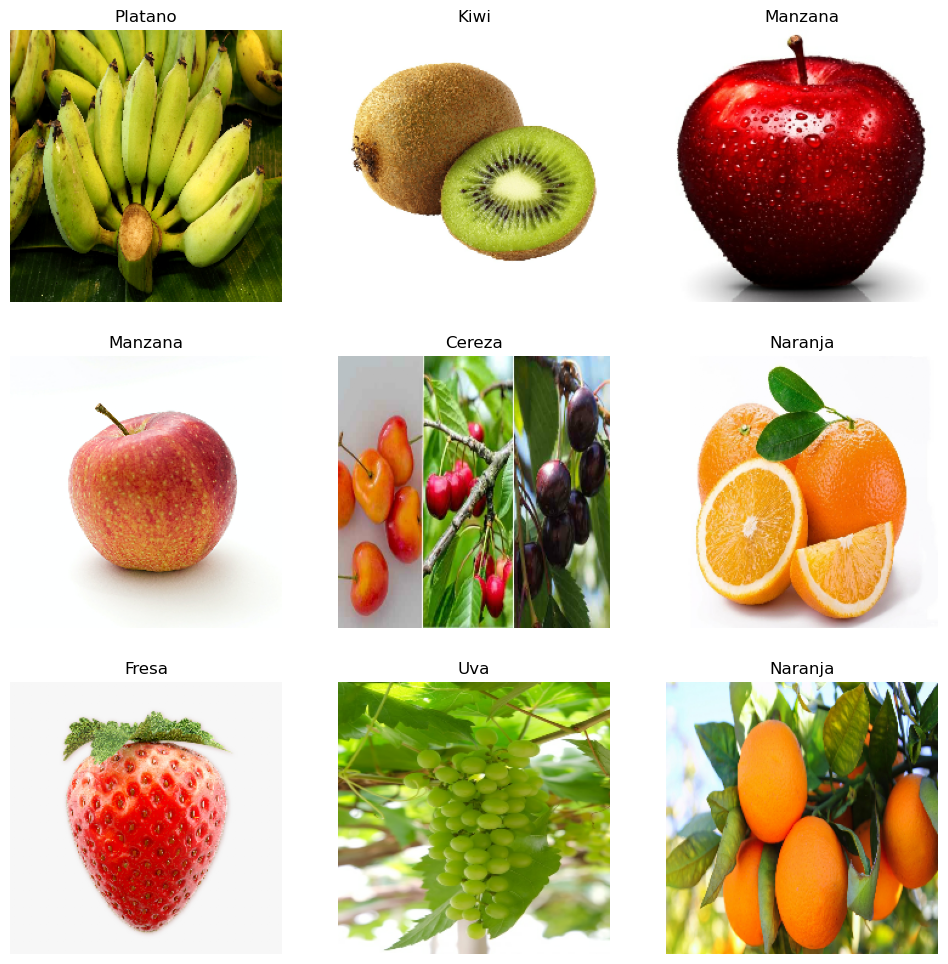

In [ ]:
plt.figure(figsize=(12, 12))

#   Se seleccionan 9 imágenes random
random_indices = np.random.choice(len(X), size=9, replace=False)

#   En este caso se utilizan las imágenes normalizadas
for i, idx in enumerate(random_indices):
    img_normalized = X[idx]
    label = data_df.loc[idx, "label"]

    plt.subplot(3, 3, i + 1)

    plt.imshow(img_normalized)
    plt.title(label)

    plt.axis("off")
plt.show()

## **Entrenamiento**

In [28]:
#   Se aplanan los conjuntos de entrenamiento y prueba para que cada imagen sea un vector 1D
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Se inicializa el modelo de Regresión Logística multiple
modelo = LogisticRegression(multi_class='multinomial', max_iter=1000)

# Se entrena el modelo con los datos de entrenamiento aplanados y sus etiquetas
modelo.fit(X_train_flat, Y_train)

# Realizar predicciones sobre el conjunto de prueba aplanado
predicciones = modelo.predict(X_test_flat)

# Generar y mostrar la matriz de confusión como un DataFrame de pandas
pd.DataFrame(confusion_matrix(Y_test, predicciones), columns=unique_labels, index=unique_labels)

c:\Users\orlan\anaconda3\envs\nose\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Manzana,Kiwi,Fresa,Cereza,Sapote,Naranja,Uva,Mango,Platano
Manzana,5,1,0,1,2,3,0,0,1
Kiwi,0,10,0,0,2,0,1,1,1
Fresa,6,0,5,0,1,0,1,0,0
Cereza,1,0,2,5,1,0,2,1,1
Sapote,2,0,0,0,0,0,2,3,1
Naranja,0,0,1,0,0,10,0,3,0
Uva,0,1,0,0,2,0,2,0,0
Mango,0,0,0,0,2,2,0,7,2
Platano,0,2,0,2,1,1,0,1,7


## **Métricas**

--- Métricas de Evaluación ---
Accuracy: 0.4722222222222222

Reporte de Clasificación Completo:
              precision    recall  f1-score   support

     Manzana       0.36      0.38      0.37        13
        Kiwi       0.71      0.67      0.69        15
       Fresa       0.62      0.38      0.48        13
      Cereza       0.62      0.38      0.48        13
      Sapote       0.00      0.00      0.00         8
     Naranja       0.62      0.71      0.67        14
         Uva       0.25      0.40      0.31         5
       Mango       0.44      0.54      0.48        13
     Platano       0.54      0.50      0.52        14

    accuracy                           0.47       108
   macro avg       0.46      0.44      0.44       108
weighted avg       0.51      0.47      0.48       108



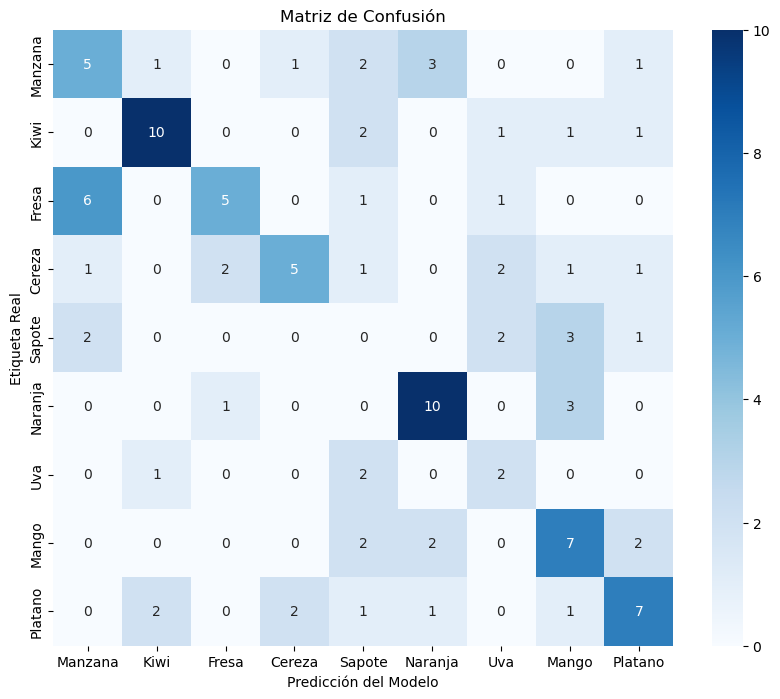

In [32]:
#   Métricas numéricas
print("--- Métricas de Evaluación ---")
print("Accuracy:", accuracy_score(Y_test, predicciones))
print("\nReporte de Clasificación Completo:")
print(classification_report(Y_test, predicciones, target_names=unique_labels))  #   target_names pone los nombres de los animales en lugar de números 0,1,2,3

#   Gráfica de la Matriz de Confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(Y_test, predicciones)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción del Modelo')
plt.title('Matriz de Confusión')
plt.show()